In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
import  matplotlib.pyplot as plt
import torch
from torch import  nn,optim
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
import  matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_percentage_error
import random
import torch
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=521)

In [2]:
train= pd.read_excel('../dataset/pre_train.xlsx')
test= pd.read_excel('../dataset/pre_test.xlsx')

ind=[i for i in train.columns][1:-1]
#1  离群点删除
def opt(opt_rate,df,threshold):
    AQindex=[]
    train=df
    threshold_num=threshold*len(df)
    for inx in ind:
        max=train.loc[:, inx].max()
        min=train.loc[:, inx].min()
        diff=max-min
        diffmin=min+opt_rate*diff
        diffmax=min+(1-opt_rate)*diff
        minlist=train[train[inx] < diffmin].index.values.tolist()
        maxlist=train[train[inx] > diffmax].index.values.tolist()

        if len(minlist) <= threshold_num:
            # print(f'min{inx}')
            # print(len(minlist))
            for minindex in train[train[inx] < diffmin].index.values.tolist():
                AQindex.append(minindex)

        if len(maxlist) <= threshold_num:
            # print(f'max{inx}')
            # print(len(maxlist))
            for maxindex in train[train[inx] > diffmax].index.values.tolist():
                AQindex.append(maxindex)
    AQindex=list(set(AQindex))
    # print(AQindex)
    AQindex=sorted(AQindex)
    return AQindex
optindex=opt(opt_rate=0.1,df=train,threshold=0.015)
train=train.drop(index=optindex).reset_index(drop=True)

data = pd.concat([train,test]).reset_index(drop=True)

#2  时间特征
def add_datetime_feats(df):
    df['time'] = pd.to_datetime(df['time'])
    # df['year']=df['year'].dt.year  # 获取年
    # df['month']=df['month'].dt.month  # 获取月
    # df['day'] = df['time'].dt.day       # 获取天
    df['hour'] = df['time'].dt.hour
    df['minute']=df['time'].dt.minute  # 获取分钟
    df['weekday']=df['time'].dt.weekday
    df['ts']=df['hour']*60+df['minute']  # 判断是一年的第几个季度
    return df
data= add_datetime_feats(data)

#3 去除率指标
data['Var_COD']=data['WI_COD']-data['WO_COD']
data['Var_AN']=(data['WI_AN']-data['WO_AN'])
data['Var_TN']=(data['WI_TN']-data['WO_TN'])
data['Var_AR_DO']=data['AR_WODO']-data['AR_WIDO']
data['Var_AR_AN']=(data['WI_AN']-data['AR_AN'])


data['RM_COD']=(data['WI_COD']-data['WO_COD'])/data['WI_COD']
data['RM_AN']=(data['WI_AN']-data['WO_AN'])/data['WI_AN']
data['RM_TN']=(data['WI_TN']-data['WO_TN'])/data['WI_TN']
data['RM_AR_DO']=(data['AR_WODO']-data['AR_WIDO'])/data['AR_WODO']
data['RM_AR_AN']=(data['WI_AN']-data['AR_AN'])/data['WI_AN']



#4 时序上的滚动特征
roll_cols = ['WI_F',
 'WI_T',
 'WI_COD',
 'WI_TN',
 'WI_AN',
 'WO_F',
 'WO_T',
 'WO_COD',
 'WO_TN',
 'WO_AN',
 'AR_MLSS',
 'AR_AN',
 'AR_NN',
 'AR_WIDO',
 'AR_WODO',
 'AR_F']
for i in [j for j in range(1, 6)] + [10, 15, 20, 30, 60, 120]:
    # data[[ii+f'_delta_{i}' for ii in roll_cols]] = data[roll_cols].diff(periods=i)
    data[[ii+f'_mean_{i}' for ii in roll_cols]] = data[roll_cols].rolling(i, min_periods=1).mean()


#根据方差只保留save_rate的特征数量
pd.set_option("display.max_columns", 100)
save_rate = 0.8
data = data[data.describe().T.sort_values(by="std", ascending=False, inplace=False).iloc[: int(len(data.columns)*save_rate)].index.tolist()]

train = data.iloc[:train.shape[0]].reset_index(drop=True)
test = data.iloc[train.shape[0]:].reset_index(drop=True)





In [4]:
X_columns = [col for col in train.columns if col not in ['time','AQ','hour','minute','weekday','ts']]
Y_columns =['AQ']

x_train=train[X_columns]
y_train=train[Y_columns]
x_test=test[X_columns]
y_test=test[Y_columns]

In [5]:
# device=torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("*********************")
print(torch.cuda.get_device_name(0))
print(device)

*********************
NVIDIA GeForce RTX 3070 Laptop GPU
cuda:0


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler1=MinMaxScaler(feature_range=(0.000000001,1))
scaler2=MinMaxScaler(feature_range=(0.000000001,1))
scaler3=MinMaxScaler(feature_range=(0.000000001,1))
scaler4=MinMaxScaler(feature_range=(0.000000001,1))
train_sca=pd.DataFrame()
test_sca=pd.DataFrame()
train_sca[X_columns]=scaler1.fit_transform(train[X_columns])
train_sca[Y_columns]=scaler2.fit_transform(train[Y_columns])
test_sca[X_columns]=scaler3.fit_transform(test[X_columns])
test_sca[Y_columns]=scaler4.fit_transform(test[Y_columns])


In [8]:
input_size=len(X_columns)
output_size=len(Y_columns)

hidden_size=32
num_layers=8

seq=32
batch_size=32

epochs=10




In [9]:
type(train_sca)

pandas.core.frame.DataFrame

In [10]:
def split_data(train_sca,test_sca,seq,X_columns,Y_columns): #47预测1


    data_raw=pd.concat([train_sca,test_sca])

    data=[]
    for index in range(len(data_raw)-seq):
        data.append(data_raw[index:index+seq])
    data=np.array(data)
    # print(len(data))  #14640
    test_set_size=len(test_sca)  #96
    train_set_size=data.shape[0]-test_set_size

    # 第一个-1是47预测1
    #第二个1是不计time，-1是只预测AQ
    x_train=data[:train_set_size,:-1,:len(X_columns)].astype('float32')
    y_train=data[:train_set_size,-1,-len(Y_columns)].reshape(-1,len(Y_columns)).astype('float32')

    x_test=data[train_set_size:,:-1,:len(X_columns)].astype('float32')
    y_test=data[train_set_size:,-1,-len(Y_columns)].reshape(-1,len(Y_columns)).astype('float32')

    def nptotorch(inputdata):
        return torch.from_numpy(inputdata).to(device)
    x_train_ts= nptotorch(x_train)
    y_train_ts= nptotorch(y_train)
    x_test_ts= nptotorch(x_test)
    y_test_ts= nptotorch(y_test)

    return [x_train_ts,y_train_ts,x_test_ts,y_test_ts]


x_train_ts,y_train_ts,x_test_ts,y_test_ts=split_data(
    train_sca=train_sca,
    test_sca=test_sca,
    seq=seq,
    X_columns=X_columns,
    Y_columns=Y_columns)
print(x_train_ts.shape)
print(y_train_ts.shape)
print(x_test_ts.shape)
print(y_test_ts.shape)

torch.Size([12680, 31, 162])
torch.Size([12680, 1])
torch.Size([480, 31, 162])
torch.Size([480, 1])


In [11]:
import  torch.nn as nn
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size


        self.lstm=nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True,dropout=0.5)
        self.fc=nn.Linear(self.hidden_size,self.output_size)


    def forward(self,train):
        batch_size, seq_len = train.shape[0],train.shape[1]

        h0=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)

        out,(hn,cn)=self.lstm(train,(h0.detach(),c0.detach()))
        out = self.fc(out)
        output = out[:, -1,:]


        return output

In [12]:
model =LSTM(input_size=input_size,hidden_size=hidden_size,output_size=output_size,num_layers=num_layers).to(device)


# def MAPE(y_true, y_pred):
#     with np.errstate(divide='ignore', invalid='ignore'):
#         if np.isnan(null_val):
#             mask = ~np.isnan(y_t)
#         else:
#             mask = np.not_equal(y_t, null_val)
#         mask = mask.astype('float32')
#         mask /= np.mean(mask)
#         mape = np.abs(np.divide(np.subtract(y_p, y_t).astype('float32'),
#                       y_t))
#         mape = np.nan_to_num(mask * mape)
#         return np.mean(mape)

myloss=nn.MSELoss()
optimiser=torch.optim.Adam(model.parameters(),lr=0.001)


In [13]:
import time
start_time=time.time()
hist=np.zeros(epochs)

lstm=[]

from torch.utils import data
torch_dataset = data.TensorDataset(x_train_ts, y_train_ts)
train_iter=data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)



In [ ]:
for epoch in range(epochs):
    for inx,(X, Y) in enumerate(train_iter):
        Y_pred=model(X)
        loss =myloss(Y,Y_pred)

        #梯度清0
        optimiser.zero_grad()
        #计算梯度
        loss.backward()
        #修改权值
        optimiser.step()
        if inx%100==99:
            print(f' {inx+1}loss {loss.item():f}')
        torch.cuda.empty_cache()


    print('************************************')
    print(f'epoch {epoch+1}, loss {loss.item():f}')
    print('************************************')

# for t in range(epochs):
#
#     y_train_pred=model(x_train)
#
#     loss =myloss(y_train,y_train_pred)
#     print('Epoch',t,'MSE',loss.item())
#     hist[t]=loss.item()
#
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

training_time=time.time()-start_time
print(f'training_time{training_time}')

In [15]:
# torch.save(model, "./mpkl/m6_lstm.pkl")

In [16]:

# import torch
# m18_LSTM= torch.load("./mpkl/m6_lstm.pkl")


In [17]:
from sklearn.metrics import mean_absolute_percentage_error
y_test_pred_ts = model(x_test_ts)
y_test_pred = y_test_pred_ts.detach().cpu().numpy().reshape(480,1)
# print(y_test_pred.shape)
# print(test_sca[Y_columns])
# loss=mean_absolute_percentage_error(test_sca[Y_columns],y_test_pred)
# print('MAPE:', loss)

In [28]:
test_index=test.index
y_test_pred_ts = model(x_test_ts)
y_test_pred = y_test_pred_ts.detach().cpu().numpy().reshape(480,1)
y_test_pred=scaler4.inverse_transform(y_test_pred)
y_test_pred=pd.DataFrame(columns=['AQ'],data=y_test_pred)

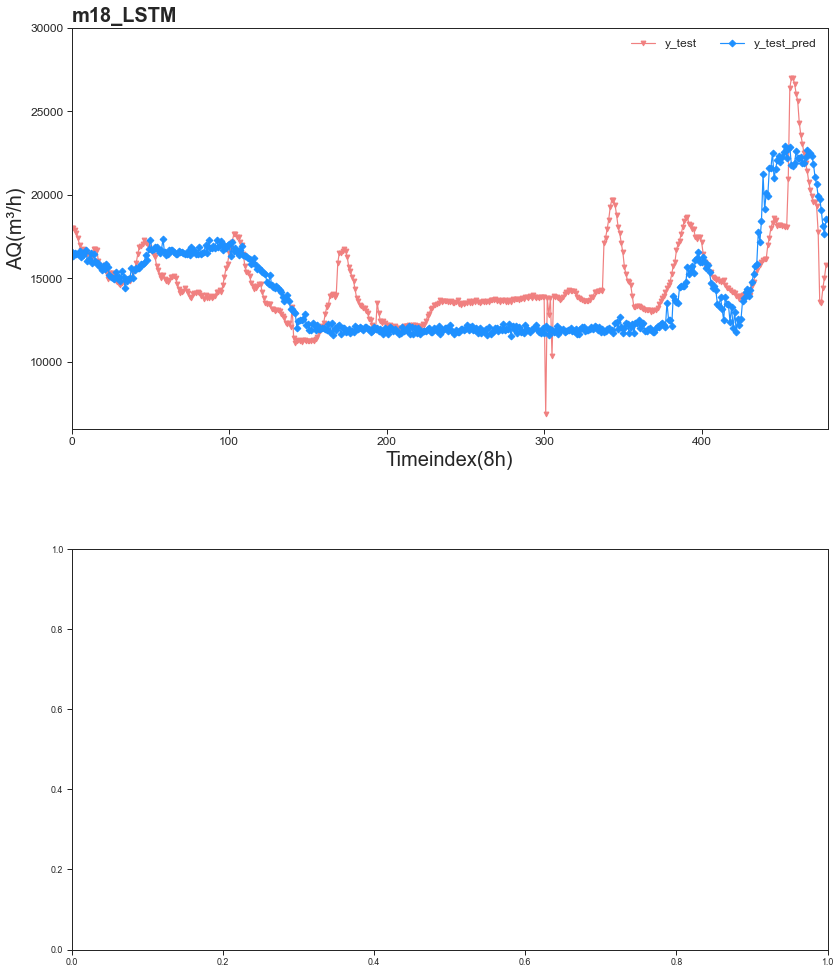

In [30]:
import seaborn as sns
sns.set(context='paper', style='ticks')

fig,axes=plt.subplots(2,1,figsize=(15,16))
ax1=axes[0]
ax2=axes[1]
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)


x=test_index
y1=y_test['AQ']
y2=y_test_pred['AQ']
lns1=ax1.plot(x,y1,label='y_test',marker='v',markevery=1, color='lightcoral')
lns2=ax1.plot(x,y2,label='y_test_pred',marker='D',markevery=1, color='dodgerblue')
ax1.tick_params(labelsize=12)
ax1.set_xlim(0,480,1)
ax1.set_ylim(6000,30000, 5000)
ax1.set_xlabel('Timeindex(8h)',size=20)
ax1.set_ylabel('AQ(m³/h)',size=20)
ax1.set_title('m18_LSTM',size=20,fontweight='bold',loc='left')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1,fontsize=12,ncol=2,frameon=False)

In [31]:
frame=pd.DataFrame()

frame['ytest']=y_test_pred




In [32]:
frame.to_excel('../secondgoaldata/m6_LSTM.xlsx')